In [1]:
import numpy as np
from netCDF4 import Dataset 
import xarray as xr

import matplotlib.pyplot as plt         # to generate plots
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

# reading in the cpc precipitation data

iniyr  = 1948
endyr  = 2017
nyr    = endyr - iniyr +1

inindx = 12*(iniyr-1948)
endndx = 12*(endyr-1948+1)

ncfile2 = '/data/obs_data/CPC_CONUS/monthly/precip.V1.0.mon.mean.nc'

fprc = xr.open_dataset(ncfile2)
fprc = fprc.assign_coords(lon=((fprc.lon + 180) % 360) - 180).sortby('lon')  # Convert lon from 0-359 to -180-179
prc =  fprc.precip[inindx:endndx,:,:]
lon_prc  =  fprc.lon
lat_prc  =  fprc.lat 
time_prc = fprc.time[inindx:endndx]
prc.dims

('time', 'lat', 'lon')

In [2]:
# Calculating seasonal climatologies

def annual_mean(df):
    return df.groupby('time.year').mean(dim = 'time')

prc_seas = prc.groupby('time.season').apply(annual_mean)
prc_seas = prc_seas.transpose(*['year','season','lat','lon'])
prc_seas.dims


/home/amirerf/.conda/envs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


('year', 'season', 'lat', 'lon')

In [3]:
# creat another lat/lon grid and transfer the data from the original grid to the new one 

import xesmf as xe

ds_in = xr.Dataset({'lat': (['lat'], lat_prc),'lon': (['lon'], lon_prc)} )
ds_out = xr.Dataset({'lat': (['lat'], lat_prc[::4]),'lon': (['lon'], lon_prc[::4])} )

regridder = xe.Regridder(ds_in, ds_out, 'bilinear')

prc_HR = prc_seas.copy()
prc_LR = regridder(prc_HR)

Overwrite existing file: bilinear_120x300_30x75.nc 
 You can set reuse_weights=True to save computing time.


/home/amirerf/.conda/envs/py37/lib/python3.7/site-packages/xesmf/smm.py:70: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


/home/amirerf/.conda/envs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'Low Reslution data')

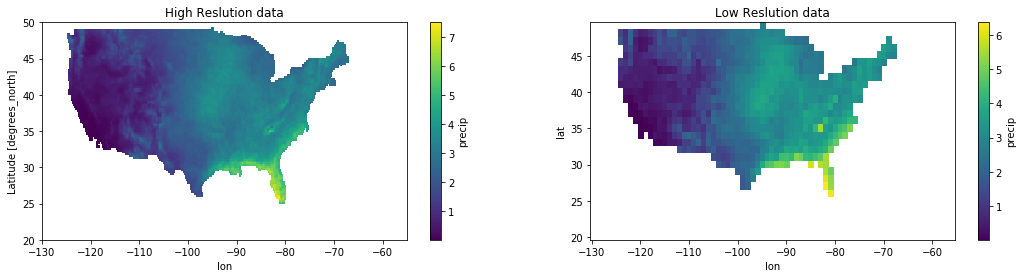

In [4]:
# plotting seasonal mean precipiation for JJA

fig1 = plt.figure(figsize=(18,4))

ax1 = fig1.add_subplot(121)
ax2 = fig1.add_subplot(122)

prc_HR.sel(season='JJA').mean(dim = 'year').plot(ax=ax1) ; ax1.set_title('High Reslution data')
prc_LR.sel(season='JJA').mean(dim = 'year').plot(ax=ax2) ; ax2.set_title('Low Reslution data')